# ERROR ANALYSIS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys
sys.path.append('../../')
from datasets.prediction import load
from models.metrics import metrics_regression
import warnings
warnings.filterwarnings('ignore')
from tools.columns import num2cal
from plot_error import total_metrics, per_reference_metrics

### data

In [2]:
# load
data, col = load()
# preparation
data['hour'] = [i.hour for i in data.index.tolist()]
data['month'] = [i.month for i in data.index.tolist()]

Load data..


### arguments 

In [3]:
sobservation = 'y'
sprediction = 'y_hat'
lvar_ref = ['hour', 'month']
nfolks = 15
nX = 8 # None
sfilter = ''

# TOOLS

In [4]:
# validation
for scol in [sobservation, sprediction] + lvar_ref:
    assert scol in data.columns, '"%s" is not available in the data.'%scol
# filter data
try:
    if len(sfilter)>0: 
        data = data.query(sfilter)
except:
    print('[error] it was not filter the data.')
# sort data
data.sort_index(inplace = True)

In [5]:
data.head()

,y,y_inv,y_hat,y_hat_inv,hour,month
dt,,,,,,
2013-01-01 11:00:00,0.668586,2206.0,0.532617,1757.371216,11,1
2013-01-01 12:00:00,0.609789,2012.0,0.477743,1576.313843,12,1
2013-01-01 13:00:00,0.512502,1691.0,0.484838,1599.721558,13,1
2013-01-01 14:00:00,0.405364,1337.5,0.349027,1151.615479,14,1
2013-01-01 15:00:00,0.109714,362.0,0.127341,420.162140,15,1


## PLOT 1: Total Metrics

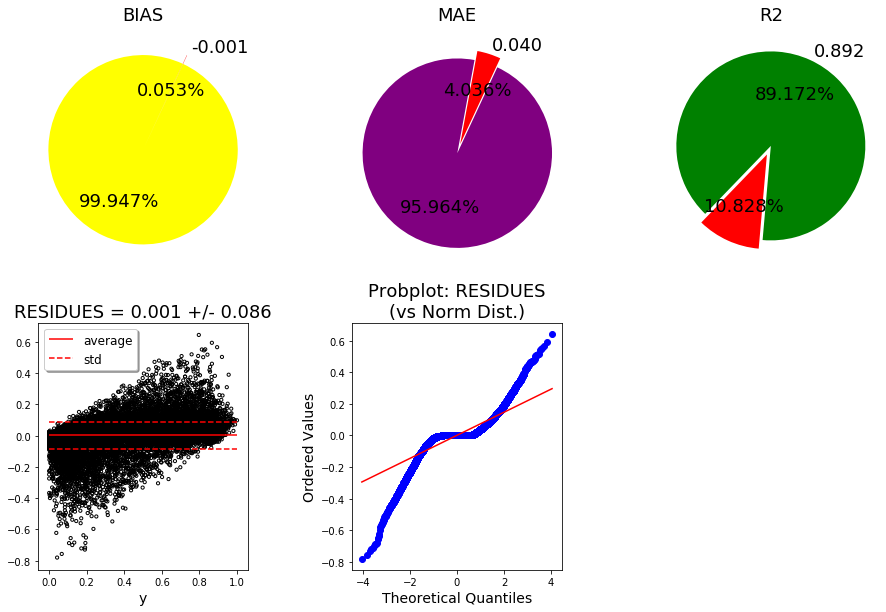

In [6]:
total_metrics(data, sobservation, sprediction, nX)

In [11]:
df = data[[sobservation]].copy()
df['residues'] = data[sobservation].values - data[sprediction].values
starget = sobservation
if data[[sobservation]].dtypes.values[0] == 'float64':
    df = num2cal(df, sobservation, np.linspace(np.min(data[sobservation].values), np.max(data[sobservation].values), 11), np.arange(10,dtype = int))
    starget = 'c%s'%sobservation

In [12]:
aggregations = {
    'residues':{
        'min':'min',
        'mean':'mean',
        'max':'max'
    }
}
dfgroup = df.groupby('cy').agg(aggregations)

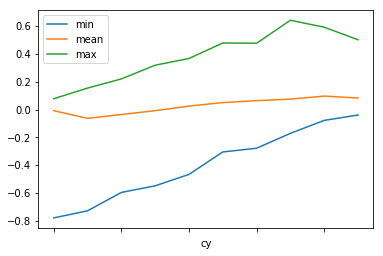

In [13]:
dfgroup.residues[['min','mean','max']].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4798537d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f47914def98>]], dtype=object)

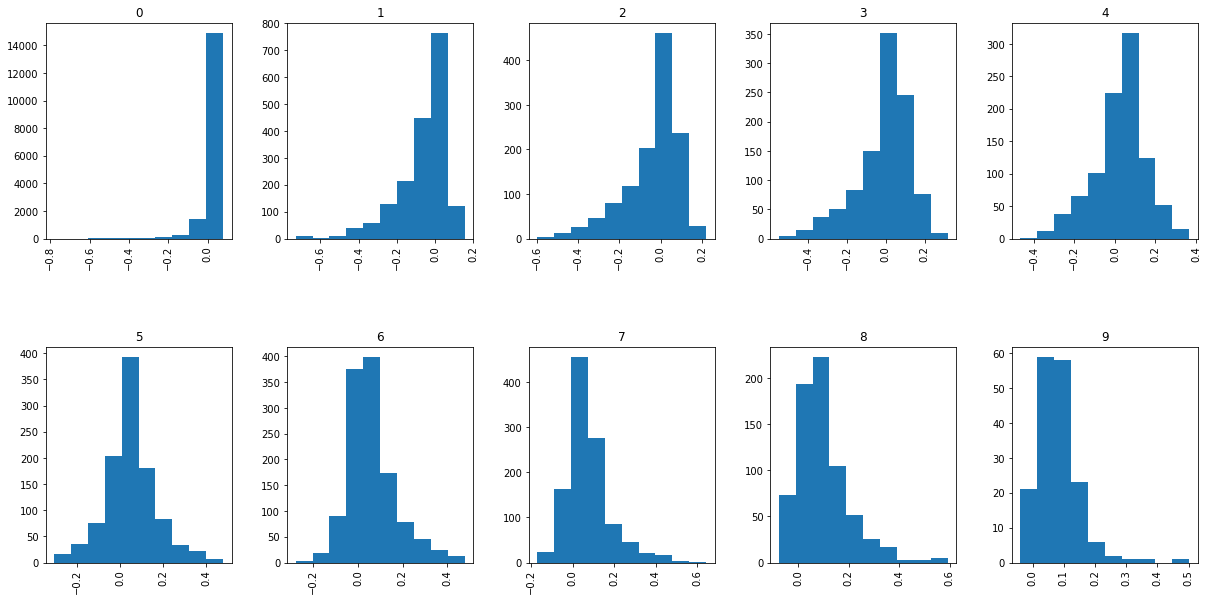

In [14]:
df.hist(column = 'residues', by='cy', layout = (2, 5),figsize = (20, 10))

# PLOT 2: Trends

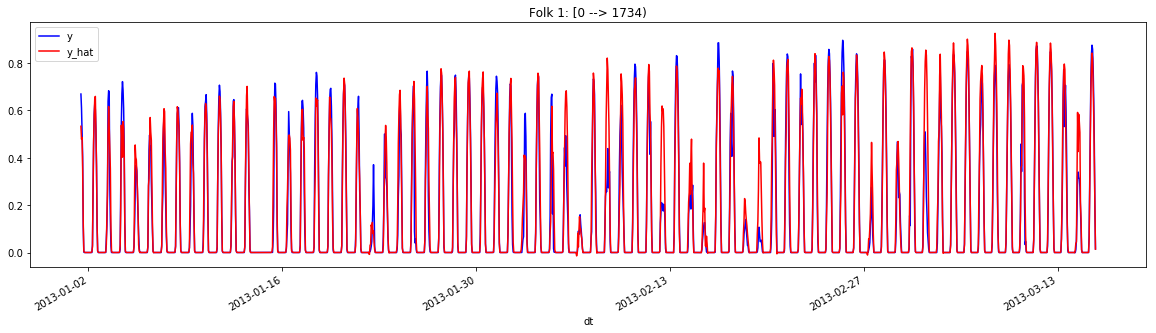

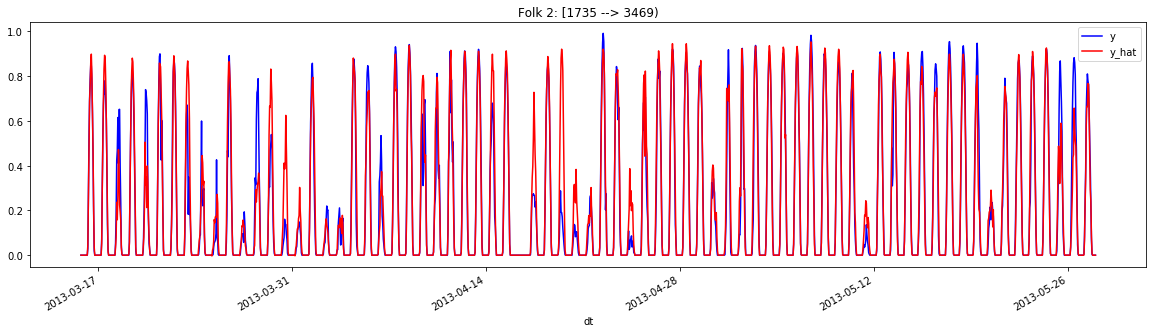

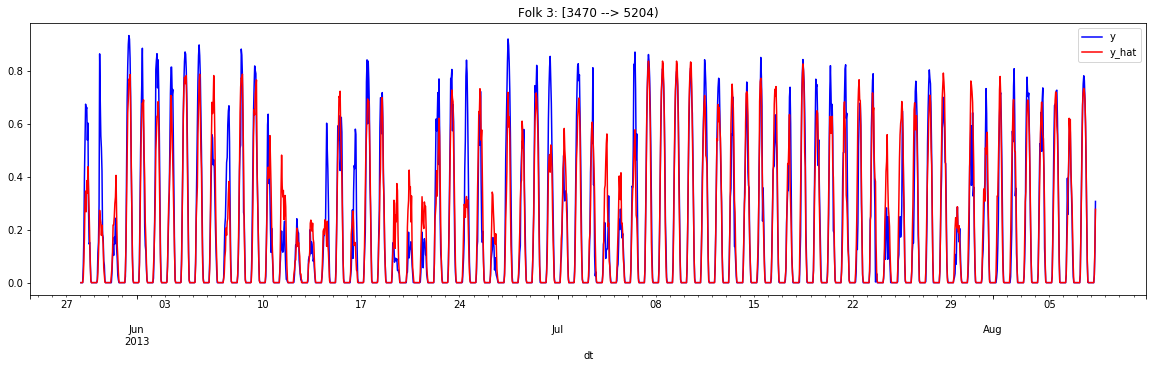

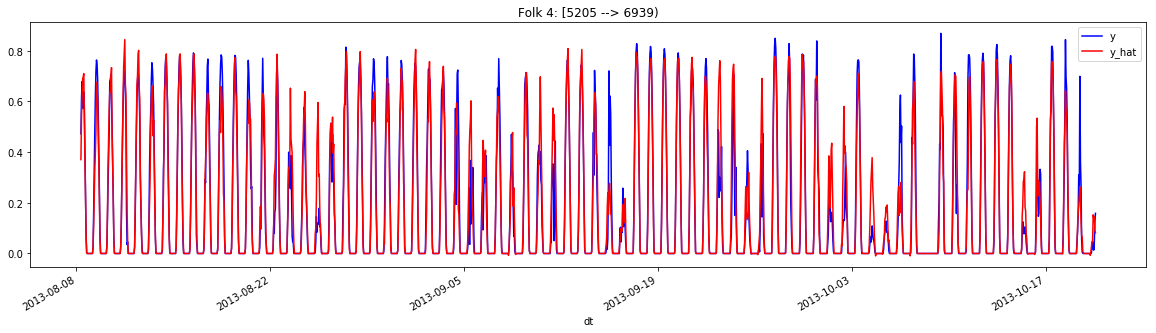

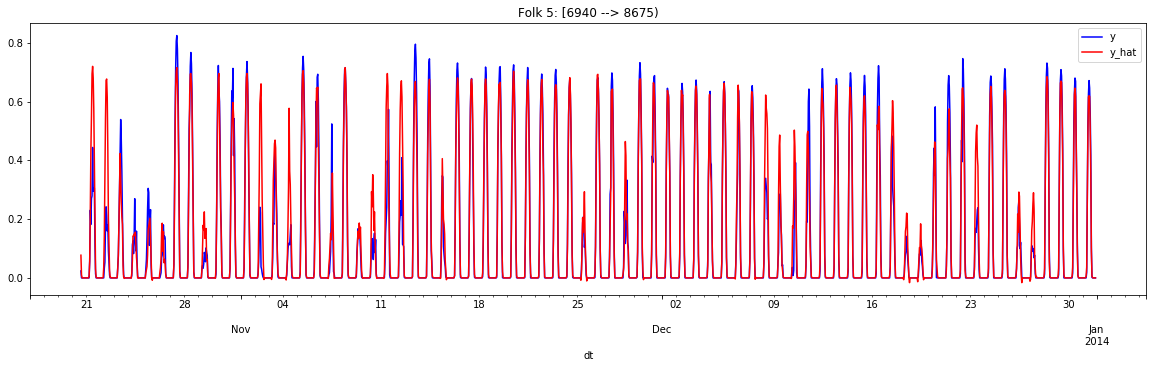

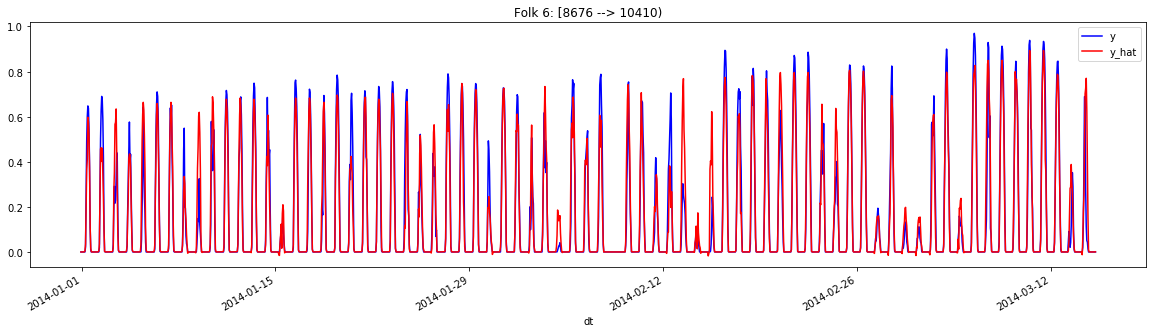

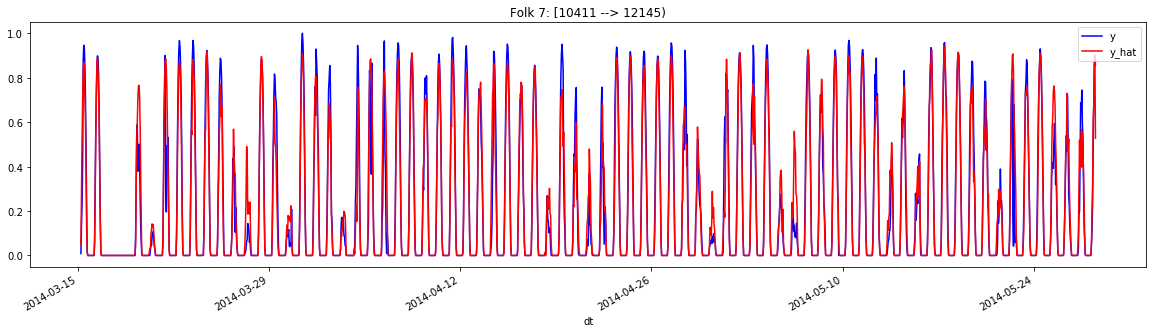

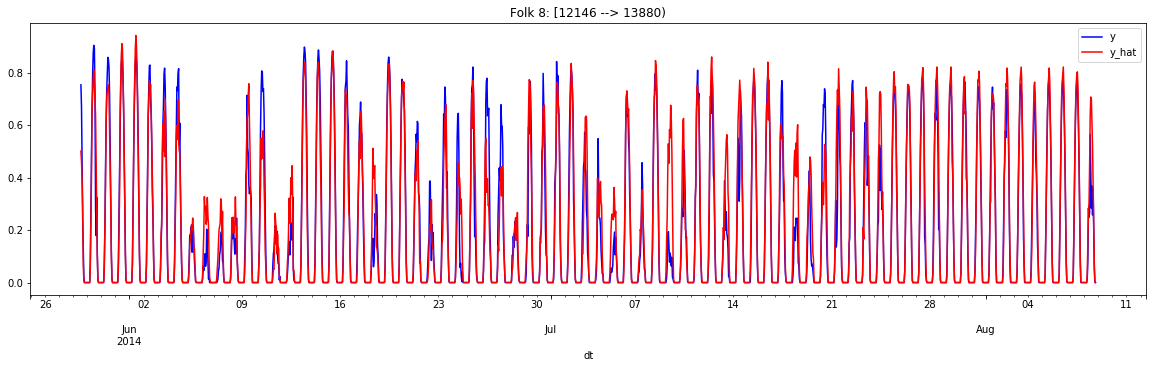

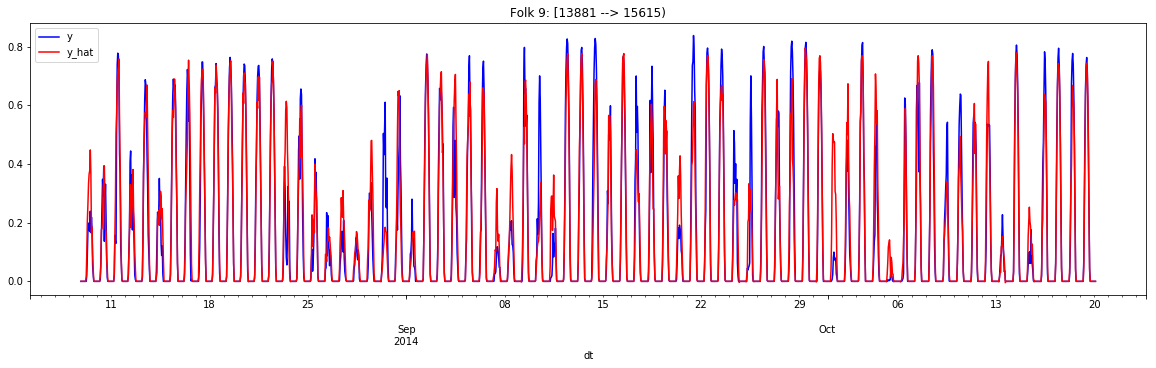

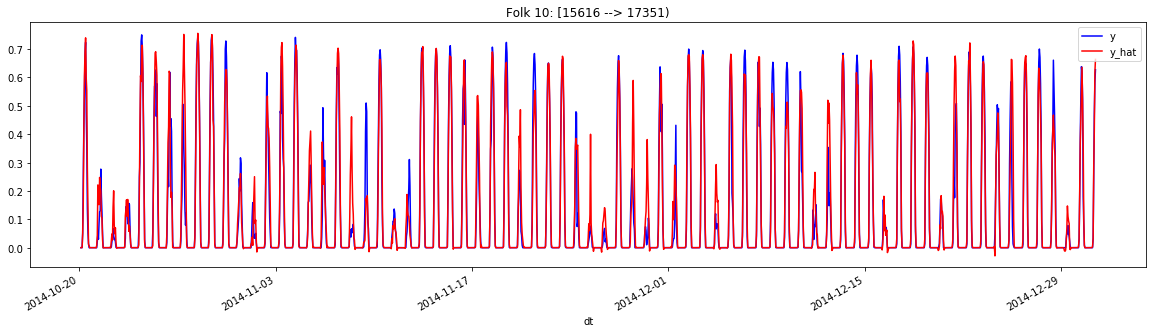

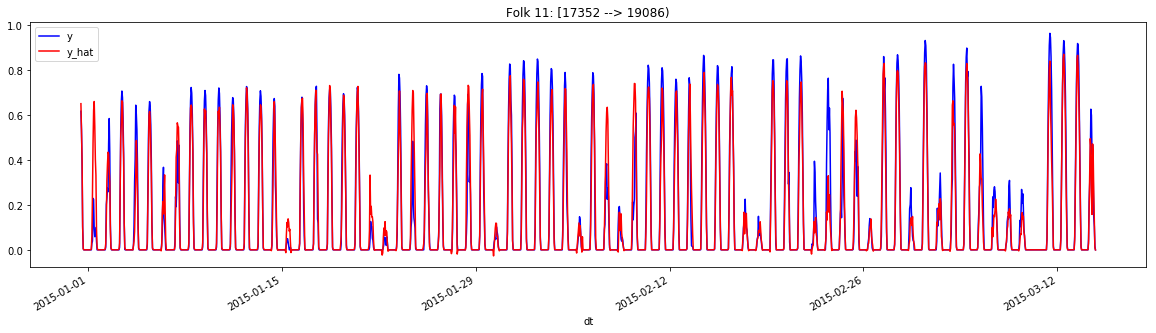

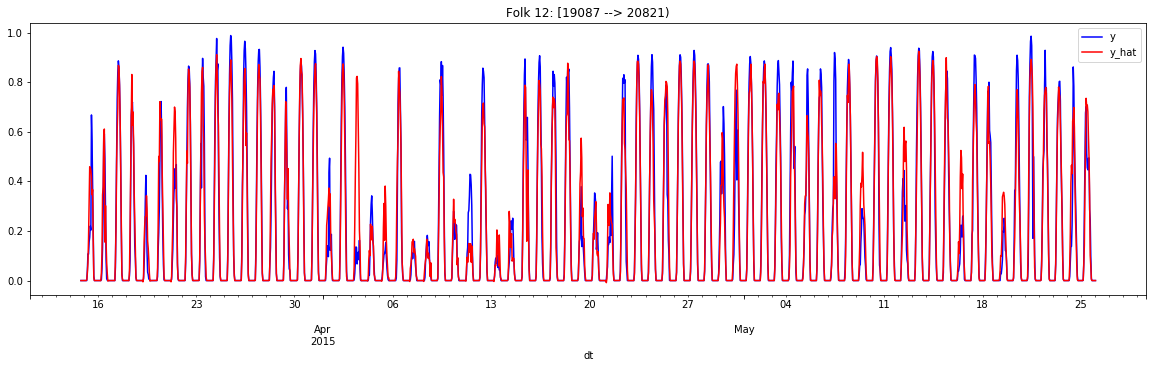

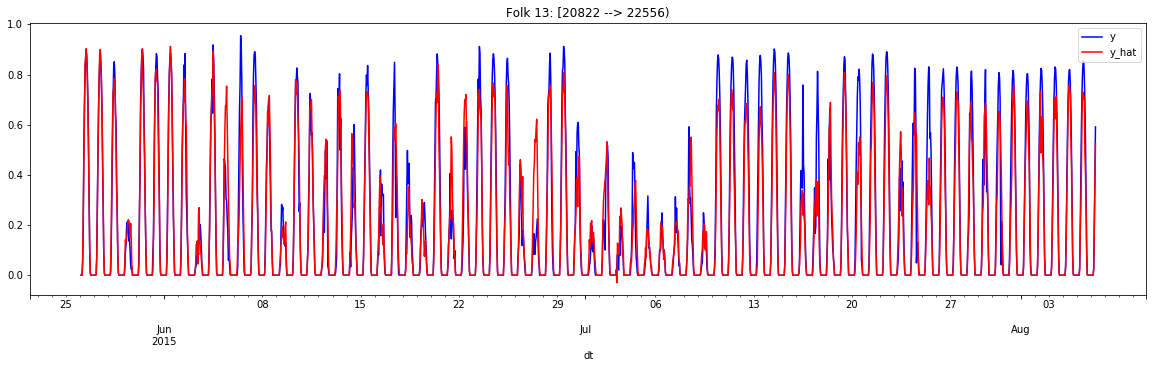

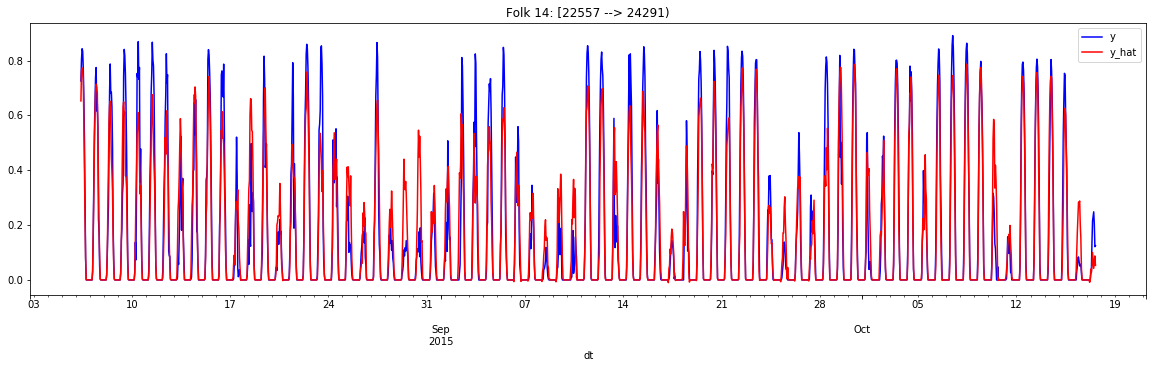

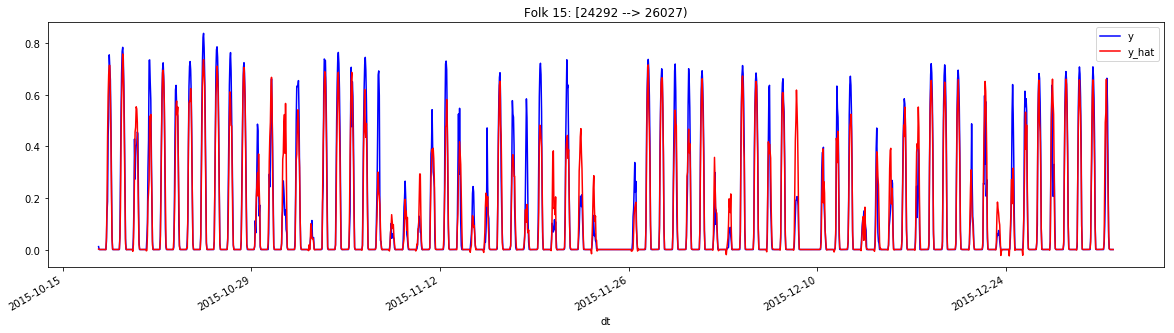

In [67]:
# trend 1: Total
import matplotlib.pyplot as plt
chunks = np.linspace(0, len(data), nfolks+1, dtype = int)
for ii in range(len(chunks)-1):
    stitle = 'Folk %s: [%s --> %s)'%(ii+1 ,chunks[ii], chunks[ii+1]-1)
    ax = data[[sobservation, sprediction]][chunks[ii]:chunks[ii+1]].plot(figsize = (20,5),title = stitle, color = ['blue', 'red'])
    ax.set_facecolor('xkcd:white')
# display
plt.show()

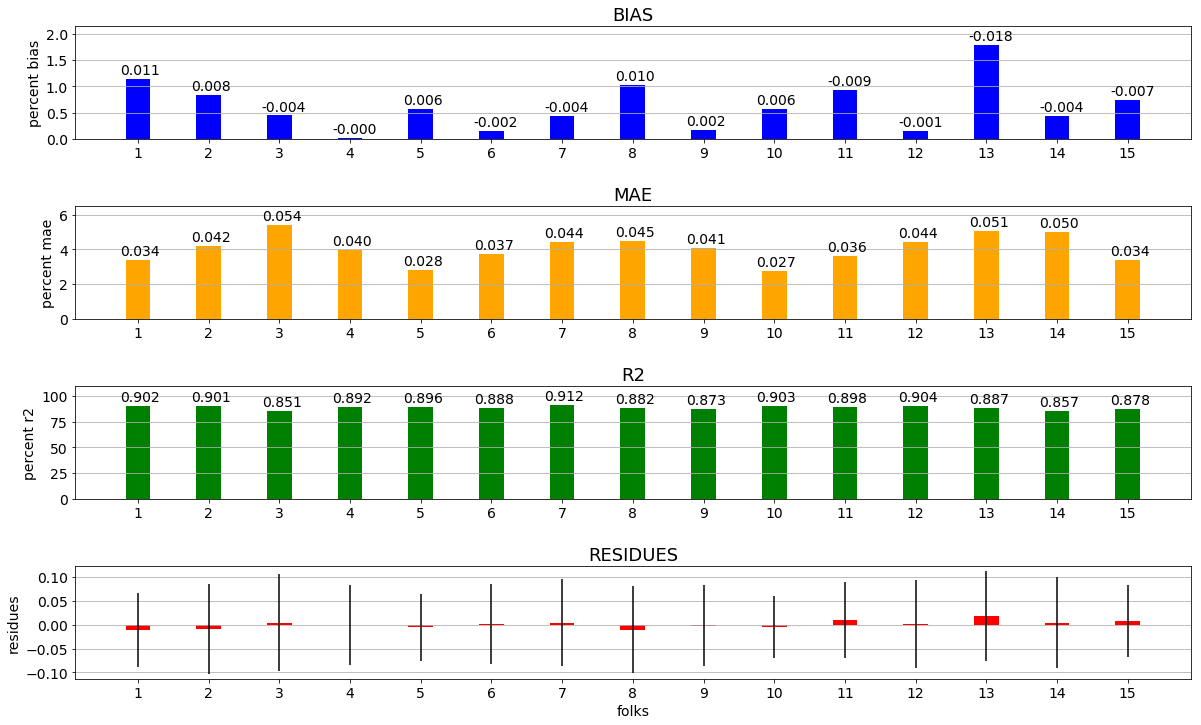

In [15]:
# trend 2: by Folks
chunks = np.linspace(0, len(data), nfolks+1, dtype = int)
lbias = list()
lmae = list()
lr2 = list()
lres_avg = list()
lres_std = list()
lfolk = list()
for ii in range(len(chunks)-1):
    # collect data
    idata = data.iloc[chunks[ii]:chunks[ii+1]]
    # calculate metrics
    dmetrics = metrics_regression(idata[sobservation].values, idata[sprediction].values, k = nX)
    ibias, imae, ir2 = dmetrics['bias'], dmetrics['mae'], dmetrics['r2']
    # calculate residues
    iresidues = idata[sobservation].values - idata[sprediction].values
    ires_avg, ires_std = np.mean(iresidues), np.std(iresidues) 
    # store
    lfolk.append(ii+1)
    lbias.append(ibias)
    lmae.append(imae)
    lr2.append(ir2)
    lres_avg.append(ires_avg)
    lres_std.append(ires_std)
resfolk = pd.DataFrame({
    'folk': lfolk,
    'bias': lbias,
    'mae': lmae,
    'r2': lr2,
    'res_avg': lres_avg,
    'res_std': lres_std
}).set_index('folk')

# calculate percentages
resfolk['pbias'] = resfolk['bias'].apply(lambda x: np.abs(x)*100./np.max(data[sobservation].values))
resfolk['pmae'] = resfolk['mae'].apply(lambda x: np.abs(x)*100./np.max(data[sobservation].values))
resfolk['pr2'] = resfolk['r2'].apply(lambda x: np.abs(x)*100.)

## PLOT PER FOLKS
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(20,12))

# bar: BIAS
ax1 = plt.subplot2grid((4,1),(0,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pbias.values, width, color = 'blue')
ax1.set_title('BIAS', fontsize = 18)
ax1.set_ylim([0,np.max(resfolk.pbias.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.bias.values, resfolk.pbias.values)):
    ax1.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pbias.values)), fontsize = 14 , rotation=0)
ax1.set_ylabel("percent bias", fontsize = 14)
ax1.set_xticks(resfolk.index.tolist())
ax1.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax1.yaxis.grid(True)

# bar: MAE
ax2 = plt.subplot2grid((4,1),(1,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pmae.values, width, color = 'orange')
ax2.set_title('MAE', fontsize = 18)
ax2.set_ylim([0,np.max(resfolk.pmae.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.mae.values, resfolk.pmae.values)):
    ax2.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pmae.values)), fontsize = 14 , rotation=0)
ax2.set_ylabel("percent mae", fontsize = 14)
ax2.set_xticks(resfolk.index.tolist())
ax2.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax2.yaxis.grid(True)

# bar: R2
ax3 = plt.subplot2grid((4,1),(2,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.pr2.values, width, color = 'green')
ax3.set_title('R2', fontsize = 18)
ax3.set_ylim([0,np.max(resfolk.pr2.values)*1.2])
for i, (v, vp) in enumerate(zip(resfolk.r2.values, resfolk.pr2.values)):
    ax3.annotate('%.3f'%v, (i+1-0.25,vp+0.05*np.max(resfolk.pr2.values)), fontsize = 14 , rotation=0)
ax3.set_ylabel("percent r2", fontsize = 14)
ax3.set_xticks(resfolk.index.tolist())
ax3.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax3.yaxis.grid(True)

# bar: RESIDUES
ax4 = plt.subplot2grid((4,1),(3,0))
width = 0.35 
p1 = plt.bar(resfolk.index.tolist(), resfolk.res_avg.values, width, color = 'red', yerr=resfolk.res_std.values)
ax4.set_title('RESIDUES', fontsize = 18)
ax4.set_xlabel("folks", fontsize = 14)
ax4.set_ylabel("residues", fontsize = 14)
ax4.set_xticks(resfolk.index.tolist())
ax4.set_xticklabels(resfolk.index.tolist(), fontsize=14)
plt.yticks(fontsize=14)
ax4.yaxis.grid(True)


# display
plt.subplots_adjust(hspace = 0.6)
plt.show()

## PLOT 3:

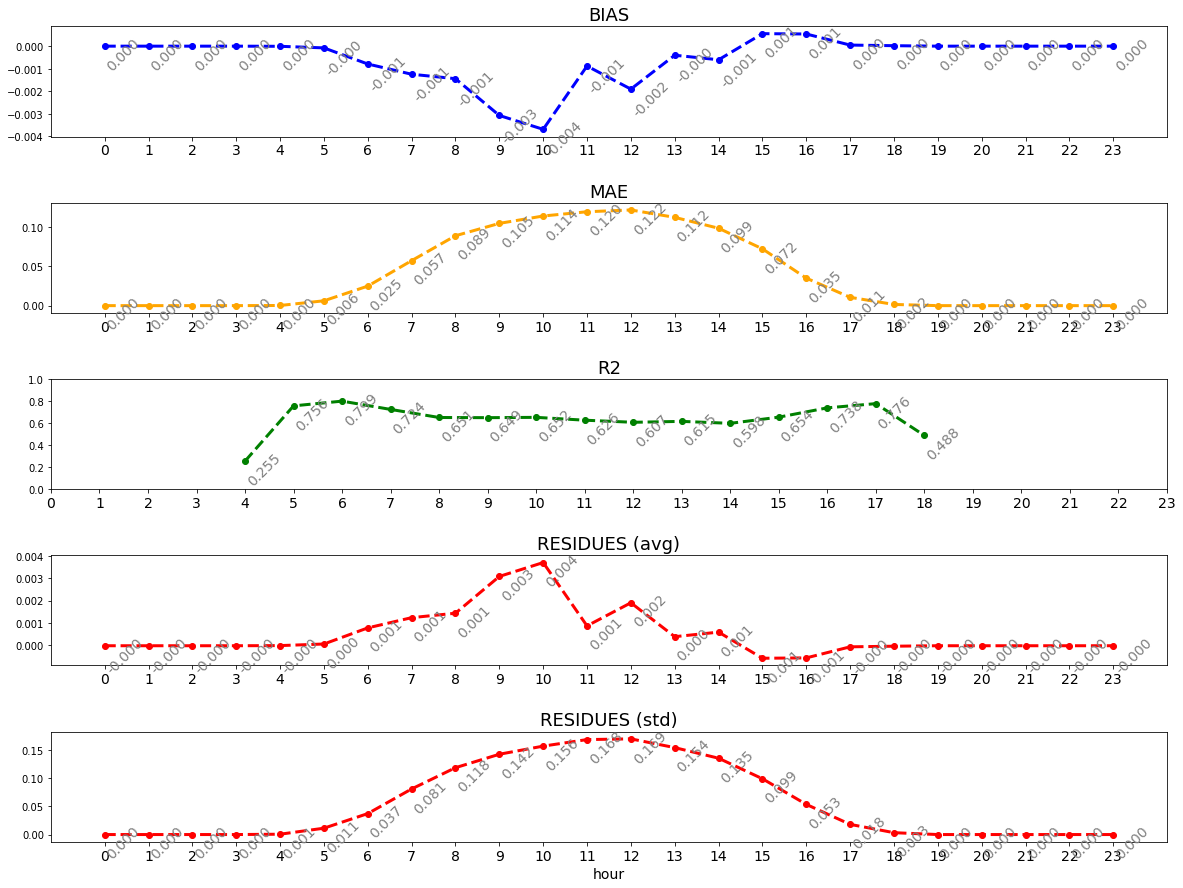

In [7]:
per_reference_metrics(data, sobservation, sprediction, lvar_ref[0])